In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('./tweets.csv')
df.date = pd.to_datetime(df.date)
df = df[~df.text.str.startswith('rt ')]
df = df[~df.text.str.startswith('RT')]
df = df.drop('Unnamed: 0', axis=1)

In [3]:
df.head()

,date,text,author
0,2016-10-14,Denying climate change is dangerous. Join @OFA...,BarackObama
1,2016-10-14,The American Bar Association gave Judge Garlan...,BarackObama
2,2016-10-14,We need a fully functional Supreme Court. Edit...,BarackObama
3,2016-10-14,"Cynics, take note: When we #ActOnClimate, we b...",BarackObama
4,2016-10-13,"""That’s how we will overcome the challenges we...",BarackObama


In [4]:
df.groupby('author').author.count()

author
BarackObama        9126
DonaldTrump       14310
HillaryClinton     5654
Name: author, dtype: int64

## Preprocessing 

#### By hand 
- lowercase 
- rid special chars (except #)
- rid punctuation 
- rid stop words
- remove links

#### With Sklearn 
- create bigrams and unigrams 
- remove words occuring < 3 times 
- remove terms in 25% of all docs 

In [5]:
import string
punc = string.punctuation.replace('#', '')
punc = punc.replace('@', '')
punc += '—'
punc += '”'
punc += '“' 
punc += '…' 
punc += '‘'

punc

'!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~—”“…‘'

In [6]:
def preprocess(x): 
    x = x.lower()
    #replace links 
    for word in x.split(): 
        if 'pic.twitter' in word:
            x = x.replace(word, '')
        if 'http' in word: 
            x = x.replace(word, '') 
    #replace special chars 
    for char in punc: 
        x = x.replace(char, '')
    x = ' '.join(x.split()) #get rid of white spaces 

    return x
    
df['process_text'] = df.text.apply(preprocess)

In [7]:
print (df.shape)
df.head(2)

(29090, 4)


,date,text,author,process_text
0,2016-10-14,Denying climate change is dangerous. Join @OFA...,BarackObama,denying climate change is dangerous join @ofa ...
1,2016-10-14,The American Bar Association gave Judge Garlan...,BarackObama,the american bar association gave judge garlan...


In [8]:
### word counts ### 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

cvec = CountVectorizer(stop_words='english', min_df=4, max_df=.25, ngram_range=(1,2))
cvec.fit(df.process_text)
cvec_counts = cvec.transform(df.process_text)
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head()

,occurrences,term
9034,4185,president
7957,3916,obama
9071,2742,president obama
4883,2086,great
11950,1983,trump


In [9]:
top_terms = counts_df.sort_values(by='occurrences', ascending=False)[:100].term.values

def generate_features(text): 
    one_hot = np.zeros(shape=top_terms.shape, dtype=int)
    for i, term in enumerate(top_terms): 
        for word in text.split(): 
            if word == term:
                one_hot[i] = 1
    return one_hot

temp = df.process_text.apply(generate_features)
temp = temp.apply(lambda x: pd.Series(x)) #split the vector into columns 
temp.columns = top_terms #rename 
df_feat = df.join(temp) 
df_feat.head(1) #spot check 

,date,text,author,process_text,president,obama,president obama,great,trump,just,...,don,youre,bad,did,house,potus,making,national,climate change,stand
0,2016-10-14,Denying climate change is dangerous. Join @OFA...,BarackObama,denying climate change is dangerous join @ofa ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Decision Tree + Visualization 

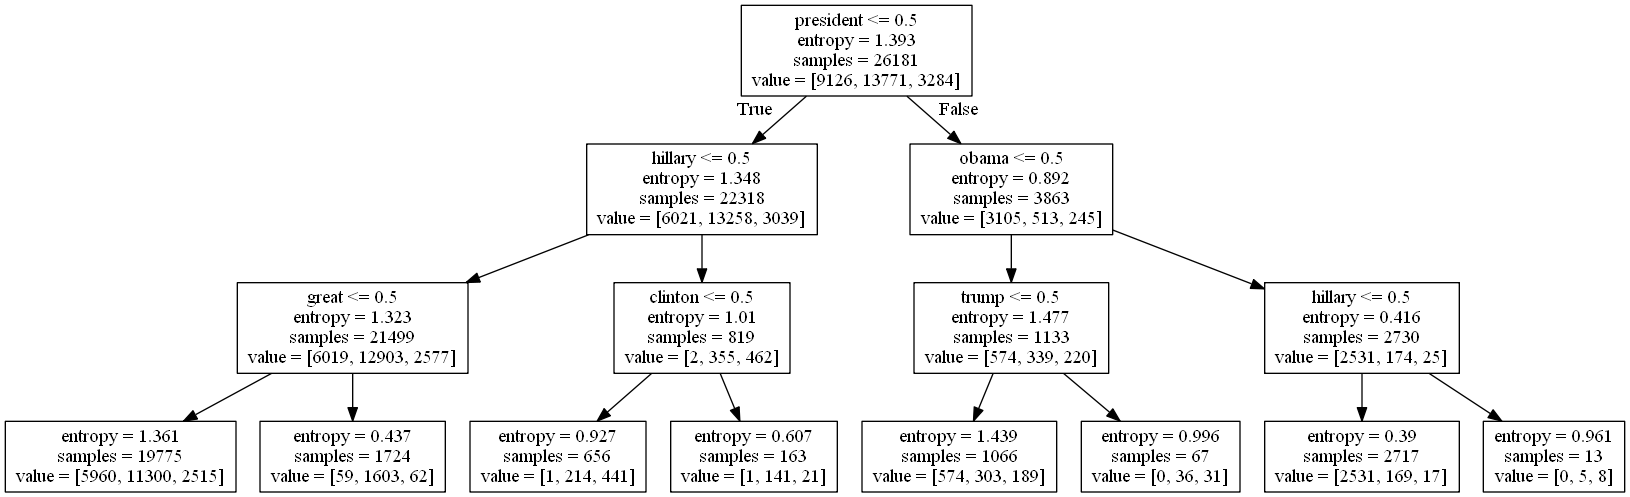

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn import tree

df_TREE = df_feat #[df_feat.author != 'HillaryClinton']

### Cross Val Decision Tree ### 
# clf = tree.DecisionTreeClassifier(random_state=0)
# scores = cross_val_score(clf, df_TREE.iloc[:, 4:], df_TREE.author, cv=10)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# print (scores)

### Decision Tree for Visualization ###

split =  int(df_TREE.shape[0]* 0.9)

clf = tree.DecisionTreeClassifier(random_state=0, 
                                 max_depth=3, #low for visibility 
                                 criterion = 'entropy')

clf = clf.fit(X = df_TREE.iloc[:split, 4:],
              y = df_TREE.author[:split])

### Visualize ###
dotfile = open("dtree2.dot", 'w')
tree.export_graphviz(clf, out_file = dotfile, feature_names = df_TREE.iloc[:, 4:].columns)
dotfile.close()
### dotfile --> png via cmd line  ###
!dot -Tpng dtree2.dot -o tree.png
from IPython.display import Image 
Image(filename='tree.png')
# !tree.png